In [37]:
InteractionsFileCaptureC='/mnt/lab_data/kundaje/mtaranov/ChicagoCalls/D0_D2D8_merge_BaitToBait_intra.bed.gz'
PromoterFile='/srv/scratch/mtaranov/HindIII/PromoterCapture_Digest_Human_HindIII_baits_ID.bed'
#PromoterFile='/srv/scratch/mtaranov/HindIII/PromoterCapture_Digest_Human_HindIII_baits_ID.bed'
PROJDIR='/users/mtaranov/NN_thres1mean_datasets/'
DATAJDIR='/users/mtaranov/NN_thres1mean_datasets/dist_matched/'

In [2]:
features_path='/srv/scratch/mtaranov/peaks_at_promoters/output_thres1_mean/'
atac=features_path+'atac'
#TFs
ctcf=features_path+'CTCF'
pol3=features_path+'PolII'
TP63=features_path+'TP63'
LSD1=features_path+'LSD1'
#histone
H3K27ac=features_path+'H3K27ac'
H3K27me3=features_path+'H3K27me3'
H3K4me1=features_path+'H3K4me1'
H3K4me3=features_path+'H3K4me3'
H3K9ac=features_path+'H3K9ac'

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.stats.mstats import mquantiles
import scipy.stats as ss
import math
import scipy.linalg
import itertools
import copy
import random
import gzip
from sets import Set
#reload(rcca)
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc, roc_curve
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform
import networkx as nx

sys.path.append('/users/mtaranov/datasets_3d')
from utils_data_process import printMatrix, set_diag_to_value, binarize, binarize_w_unlabeled, demean, zscore
from utils_data_process import shuffle_nodes, train_vali_test, build_distance_for_node, BuildMatrix, get_features
from utils_data_process import get_data_labels, remove_unlabeled, concatenate_chrs, get_pairs_distance_matched, impose_dist_constrains, count_nodes_and_contacts

/users/mtaranov/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: the sets module is deprecated


In [36]:
labels_score = BuildMatrix(PromoterFile, InteractionsFileCaptureC)

non-unique entries in CaptureC file(bait1-bait2/bait2-bait1):  1237741.0   0.49244938606 %
unique entries in CaptureC file(bait1-bait2/bait2-bait1):  1275697.0   0.50755061394 %


37.5741843787
(2846, 2846)
Limit: 37.5741843787


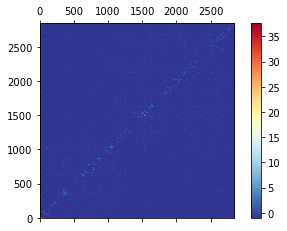

In [26]:
printMatrix(labels_score['chr16'], '', 1, 1, title='')

31.5660281516
(300, 300)
Limit: 31.5660281516


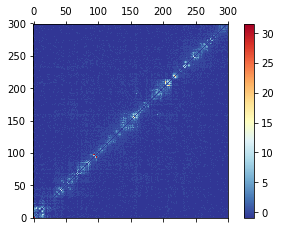

In [6]:
subset=labels_score['chr1'][[i for i in range(300)]][:, [i for i in range(300)]]
printMatrix(subset, '', 1, i, title='')

1.0
(300, 300)
Limit: 1.0


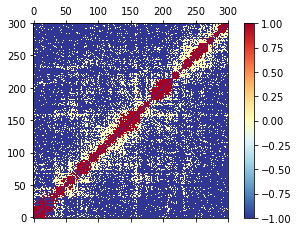

In [7]:
subset=labels_score['chr1'][[i for i in range(300)]][:, [i for i in range(300)]]
printMatrix(binarize(subset), '', 1, i, title='')

1.0
(300, 300)
Limit: 1.0


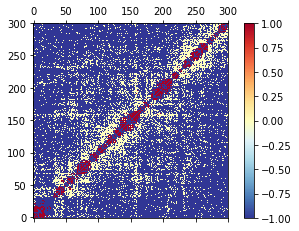

In [8]:
subset=labels_score['chr1'][[i for i in range(300)]][:, [i for i in range(300)]]
printMatrix(binarize_w_unlabeled(subset, 1), '', 1, i, title='')

1.0
(300, 300)
Limit: 1.0


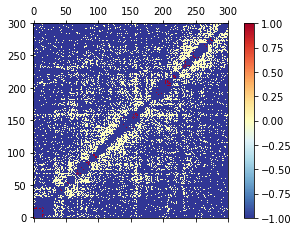

In [9]:
subset=labels_score['chr1'][[i for i in range(300)]][:, [i for i in range(300)]]
printMatrix(binarize_w_unlabeled(subset, 5), '', 1, i, title='')

Average value with zeros:  19.1889162192
Average q-value w/o zeros:  26.3905675847


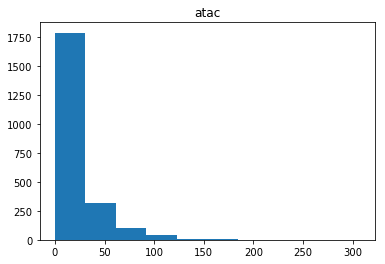

Average value with zeros:  26.138870559
Average q-value w/o zeros:  46.0011726646


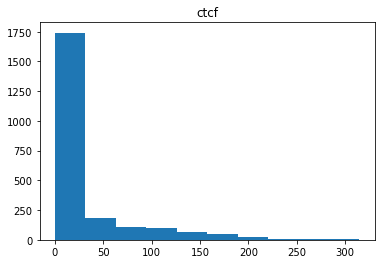

Average value with zeros:  16.41072375
Average q-value w/o zeros:  29.1290346562


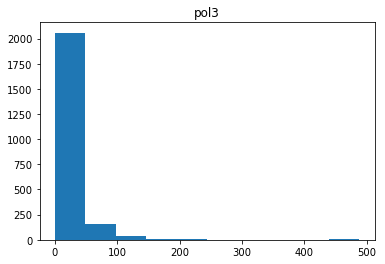

Average value with zeros:  6.64786035651
Average q-value w/o zeros:  10.7962392638


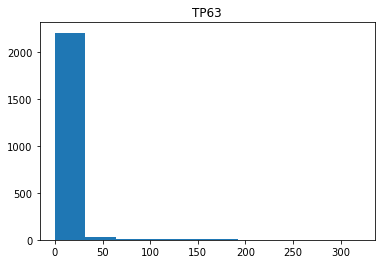

Average value with zeros:  1.21961975792
Average q-value w/o zeros:  5.99778374459


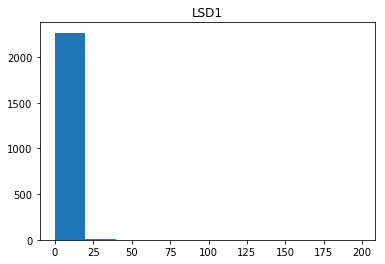

Average value with zeros:  26.4675582086
Average q-value w/o zeros:  48.456319299


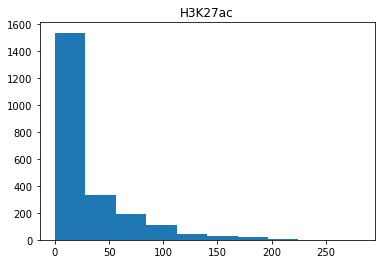

Average value with zeros:  3.21990819982
Average q-value w/o zeros:  11.9147091694


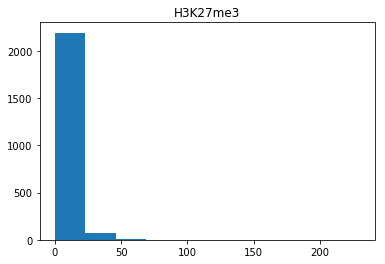

Average value with zeros:  8.79946596391
Average q-value w/o zeros:  12.5265580639


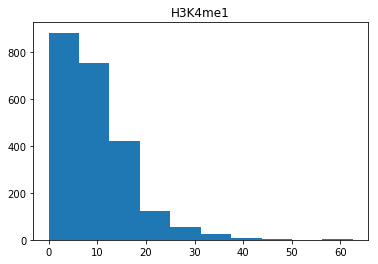

Average value with zeros:  101.908996184
Average q-value w/o zeros:  170.122879743


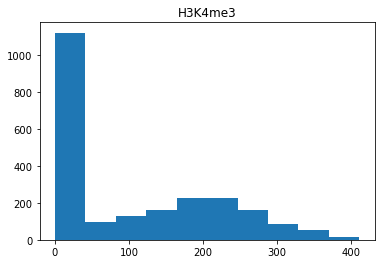

Average value with zeros:  14.533674309
Average q-value w/o zeros:  24.532323945


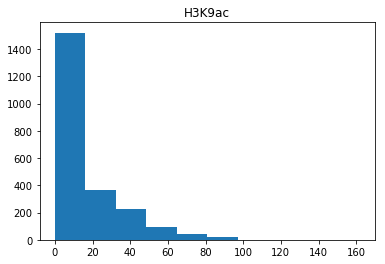

In [10]:
VectorATAC=get_features(PromoterFile, atac, 'atac')

VectorCTCF=get_features(PromoterFile, ctcf, 'ctcf')
VectorPOL3=get_features(PromoterFile, pol3, 'pol3')
VectorTP63=get_features(PromoterFile, TP63, 'TP63')
VectorLSD1=get_features(PromoterFile, LSD1, 'LSD1')

VectorH3K27ac=get_features(PromoterFile, H3K27ac, 'H3K27ac')
VectorH3K27me3=get_features(PromoterFile, H3K27me3, 'H3K27me3')
VectorH3K4me1=get_features(PromoterFile, H3K4me1, 'H3K4me1')
VectorH3K4me3=get_features(PromoterFile, H3K4me3, 'H3K4me3')
VectorH3K9ac=get_features(PromoterFile, H3K9ac, 'H3K9ac')

In [11]:
VectorATAC['chr1'].shape

(2272,)

In [12]:
distance_for_node = build_distance_for_node(PromoterFile)

In [13]:
distance_for_node['chr1'].shape

(2272, 1)

In [14]:
FeatureVector_wo_dist = {}
FeatureVector = {}
for chr in VectorATAC:
    if chr != 'chrY':
        FeatureVector_wo_dist[chr] = demean(np.vstack((VectorATAC[chr], VectorCTCF[chr], VectorPOL3[chr], VectorTP63[chr], VectorLSD1[chr], VectorH3K27ac[chr], VectorH3K27me3[chr], VectorH3K4me1[chr], VectorH3K4me3[chr], VectorH3K9ac[chr])).T)
        FeatureVector[chr] = np.concatenate((FeatureVector_wo_dist[chr], distance_for_node[chr]), axis=1)
#FeatureVectorDistance = demean(np.vstack((VectorATAC, VectorCTCF, VectorPOL3, VectorTP63, VectorLSD1, VectorH3K27ac, VectorH3K27me3, VectorH3K4me1, VectorH3K4me3, VectorH3K9ac, distance_for_node)).T)

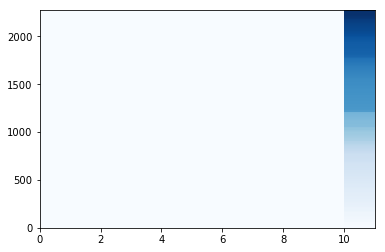

In [15]:
fig, ax = plt.subplots()
heatmap = ax.pcolor(FeatureVector['chr1'], cmap=plt.cm.Blues)
#heatmap = ax.pcolor(DistanceFeatureVectorK, cmap=plt.cm.Blues)

In [16]:
data, labels, indx  = get_data_labels(FeatureVector, labels_score)

In [22]:
data_all_chrs, labels_all_chrs, indx_all_chr = concatenate_chrs(data, labels, indx)

In [16]:
data_all_chrs_gt10kb_lt2Mb, labels_all_chrs_gt10kb_lt2Mb, indx_all_chrs_gt10kb_lt2Mb = impose_dist_constrains(data_all_chrs, labels_all_chrs, indx_all_chr, 10000, 2000000)

In [17]:
data_all_chrs_gt10kb_lt2Mb.shape

(496467, 11, 2)

In [18]:
all_at_0 = binarize_w_unlabeled(labels_all_chrs_gt10kb_lt2Mb, 0)
all_at_5 = binarize_w_unlabeled(labels_all_chrs_gt10kb_lt2Mb, 5)
all_at_10 = binarize_w_unlabeled(labels_all_chrs_gt10kb_lt2Mb, 10)

In [19]:
# data_all_wo_unlbd_at_0, labels_all_wo_unlbd_at_0 = remove_unlabeled(data_all_chrs_gt10kb_lt2Mb, binarize_w_unlabeled(labels_all_chrs_gt10kb_lt2Mb, 0))
# data_all_wo_unlbd_at_3, labels_all_wo_unlbd_at_3 = remove_unlabeled(data_all_chrs_gt10kb_lt2Mb, binarize_w_unlabeled(labels_all_chrs_gt10kb_lt2Mb, 3))
# data_all_wo_unlbd_at_5, labels_all_wo_unlbd_at_5 = remove_unlabeled(data_all_chrs_gt10kb_lt2Mb, binarize_w_unlabeled(labels_all_chrs_gt10kb_lt2Mb, 5))

In [20]:
# data_all_wo_unlbd_at_0, labels_all_wo_unlbd_at_0, indx_all_wo_unlbd_at_0 = remove_unlabeled(data_all_chrs, binarize_w_unlabeled(labels_all_chrs, 0), indx_all_chr)
# data_all_wo_unlbd_at_3, labels_all_wo_unlbd_at_3, indx_all_wo_unlbd_at_3 = remove_unlabeled(data_all_chrs, binarize_w_unlabeled(labels_all_chrs, 3), indx_all_chr)
# data_all_wo_unlbd_at_5, labels_all_wo_unlbd_at_5, indx_all_wo_unlbd_at_5 = remove_unlabeled(data_all_chrs, binarize_w_unlabeled(labels_all_chrs, 5), indx_all_chr)
# data_all_wo_unlbd_at_7, labels_all_wo_unlbd_at_7, indx_all_wo_unlbd_at_7 = remove_unlabeled(data_all_chrs, binarize_w_unlabeled(labels_all_chrs, 7), indx_all_chr)
data_all_wo_unlbd_at_10, labels_all_wo_unlbd_at_10, indx_all_wo_unlbd_at_10 = remove_unlabeled(data_all_chrs, binarize_w_unlabeled(labels_all_chrs, 10), indx_all_chr)

In [21]:
#train_set_thres_0, vali_set_thres_0, test_set_thres_0, labels_train_thres_0, labels_vali_thres_0, labels_test_thres_0, indx_train_thres_0, indx_vali_thres_0, indx_test_thres_0 =train_vali_test(data_all_wo_unlbd_at_0, labels_all_wo_unlbd_at_0, indx_all_wo_unlbd_at_0, 0.5, 0.3)

In [22]:
#train_set_thres_3, vali_set_thres_3, test_set_thres_3, labels_train_thres_3, labels_vali_thres_3, labels_test_thres_3, indx_train_thres_3, indx_vali_thres_3, indx_test_thres_3 =train_vali_test(data_all_wo_unlbd_at_3, labels_all_wo_unlbd_at_3, indx_all_wo_unlbd_at_3, 0.5, 0.3)

In [23]:
#train_set_thres_5, vali_set_thres_5, test_set_thres_5, labels_train_thres_5, labels_vali_thres_5, labels_test_thres_5, indx_train_thres_5, indx_vali_thres_5, indx_test_thres_5 =train_vali_test(data_all_wo_unlbd_at_5, labels_all_wo_unlbd_at_5, indx_all_wo_unlbd_at_5, 0.5, 0.3)

In [24]:
#train_set_thres_7, vali_set_thres_7, test_set_thres_7, labels_train_thres_7, labels_vali_thres_7, labels_test_thres_7, indx_train_thres_7, indx_vali_thres_7, indx_test_thres_7 =train_vali_test(data_all_wo_unlbd_at_7, labels_all_wo_unlbd_at_7, indx_all_wo_unlbd_at_7, 0.5, 0.3)

In [25]:
train_set_thres_10, vali_set_thres_10, test_set_thres_10, labels_train_thres_10, labels_vali_thres_10, labels_test_thres_10, indx_train_thres_10, indx_vali_thres_10, indx_test_thres_10 =train_vali_test(data_all_wo_unlbd_at_10, labels_all_wo_unlbd_at_10, indx_all_wo_unlbd_at_10, 0.5, 0.3)

Training set: 549222
Validation set: 329533
Test set: 219689


In [26]:
# min_dist=10000
# max_dist=2000000
# dist_step=10000
# class_imbalance=1
# X_test_distance_matched_at_0, y_test_distance_matched_at_0, indx_test_distance_matched_at_0  = get_pairs_distance_matched(test_set_thres_0, labels_test_thres_0, indx_test_thres_0, min_dist, max_dist, dist_step, class_imbalance)
# X_train_distance_matched_at_0, y_train_distance_matched_at_0, indx_train_distance_matched_at_0 = get_pairs_distance_matched(train_set_thres_0, labels_train_thres_0, indx_train_thres_0, min_dist, max_dist, dist_step, class_imbalance)
# X_valid_distance_matched_at_0, y_valid_distance_matched_at_0, indx_valid_distance_matched_at_0  = get_pairs_distance_matched(vali_set_thres_0, labels_vali_thres_0, indx_vali_thres_0, min_dist, max_dist, dist_step, class_imbalance)

In [27]:
# min_dist=10000
# max_dist=2000000
# dist_step=10000
# class_imbalance=1
# X_test_distance_matched_at_3, y_test_distance_matched_at_3, indx_test_distance_matched_at_3 = get_pairs_distance_matched(test_set_thres_3, labels_test_thres_3, indx_test_thres_3, min_dist, max_dist, dist_step, class_imbalance)
# X_train_distance_matched_at_3, y_train_distance_matched_at_3, indx_train_distance_matched_at_3 = get_pairs_distance_matched(train_set_thres_3, labels_train_thres_3, indx_train_thres_3, min_dist, max_dist, dist_step, class_imbalance)
# X_valid_distance_matched_at_3, y_valid_distance_matched_at_3, indx_valid_distance_matched_at_3 = get_pairs_distance_matched(vali_set_thres_3, labels_vali_thres_3, indx_vali_thres_3, min_dist, max_dist, dist_step, class_imbalance)

In [28]:
# min_dist=10000
# max_dist=2000000
# dist_step=10000
# class_imbalance=1
# X_test_distance_matched_at_5, y_test_distance_matched_at_5, indx_test_distance_matched_at_5 = get_pairs_distance_matched(test_set_thres_5, labels_test_thres_5, indx_test_thres_5, min_dist, max_dist, dist_step, class_imbalance)
# X_train_distance_matched_at_5, y_train_distance_matched_at_5, indx_train_distance_matched_at_5 = get_pairs_distance_matched(train_set_thres_5, labels_train_thres_5, indx_train_thres_5, min_dist, max_dist, dist_step, class_imbalance)
# X_valid_distance_matched_at_5, y_valid_distance_matched_at_5, indx_valid_distance_matched_at_5 = get_pairs_distance_matched(vali_set_thres_5, labels_vali_thres_5, indx_vali_thres_5, min_dist, max_dist, dist_step, class_imbalance)

In [29]:
# min_dist=10000
# max_dist=2000000
# dist_step=10000
# class_imbalance=1
# X_test_distance_matched_at_7, y_test_distance_matched_at_7, indx_test_distance_matched_at_7 = get_pairs_distance_matched(test_set_thres_7, labels_test_thres_7, indx_test_thres_7, min_dist, max_dist, dist_step, class_imbalance)
# X_train_distance_matched_at_7, y_train_distance_matched_at_7, indx_train_distance_matched_at_7 = get_pairs_distance_matched(train_set_thres_7, labels_train_thres_7, indx_train_thres_7, min_dist, max_dist, dist_step, class_imbalance)
# X_valid_distance_matched_at_7, y_valid_distance_matched_at_7, indx_valid_distance_matched_at_7 = get_pairs_distance_matched(vali_set_thres_7, labels_vali_thres_7, indx_vali_thres_7, min_dist, max_dist, dist_step, class_imbalance)

In [30]:
min_dist=10000
max_dist=2000000
dist_step=10000
class_imbalance=1
X_test_distance_matched_at_10, y_test_distance_matched_at_10, indx_test_distance_matched_at_10 = get_pairs_distance_matched(test_set_thres_10, labels_test_thres_10, indx_test_thres_10, min_dist, max_dist, dist_step, class_imbalance)
X_train_distance_matched_at_10, y_train_distance_matched_at_10, indx_train_distance_matched_at_10 = get_pairs_distance_matched(train_set_thres_10, labels_train_thres_10, indx_train_thres_10, min_dist, max_dist, dist_step, class_imbalance)
X_valid_distance_matched_at_10, y_valid_distance_matched_at_10, indx_valid_distance_matched_at_10 = get_pairs_distance_matched(vali_set_thres_10, labels_vali_thres_10, indx_vali_thres_10, min_dist, max_dist, dist_step, class_imbalance)

distance window:  [ 10000 , 20000 ]
number of pos at distance=: 17
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
indx at dist:  (0, 3)
distance window:  [ 20000 , 30000 ]
number of pos at distance=: 10
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
indx at dist:  (0, 3)
distance window:  [ 30000 , 40000 ]
number of pos at distance=: 6
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
indx at dist:  (0, 3)
distance window:  [ 40000 , 50000 ]
number of pos at distance=: 8
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
indx at dist:  (0, 3)
distance window:  [ 50000 , 60000 ]
number of pos at distance=: 9
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
indx at dist:  (0, 3)
distance window:  [ 60000 , 70000 ]
number of pos at distance=: 8
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
indx at dist

In [31]:
# print "in all chrs:"
# y_at_0=np.concatenate((y_train_distance_matched_at_0, y_valid_distance_matched_at_0, y_test_distance_matched_at_0), axis=0)
# print "pos at thres=0: ", np.where(y_at_0 > 0)[0].shape[0]
# print "neg at thres=0: ", np.where(y_at_0 == 0)[0].shape[0]
# print "total: ", y_at_0.shape[0]

In [32]:
# print "in all chrs:"
# y_at_3=np.concatenate((y_train_distance_matched_at_3, y_valid_distance_matched_at_3, y_test_distance_matched_at_3), axis=0)
# print "pos at thres=0: ", np.where(y_at_3 > 0)[0].shape[0]
# print "neg at thres=0: ", np.where(y_at_3 == 0)[0].shape[0]
# print "total: ", y_at_3.shape[0]

In [33]:
# print "in all chrs:"
# y_at_5=np.concatenate((y_train_distance_matched_at_5, y_valid_distance_matched_at_5, y_test_distance_matched_at_5), axis=0)
# print "pos at thres=0: ", np.where(y_at_5 > 0)[0].shape[0]
# print "neg at thres=0: ", np.where(y_at_5 == 0)[0].shape[0]
# print "total: ", y_at_5.shape[0]

In [34]:
# print "in all chrs:"
# y_at_7=np.concatenate((y_train_distance_matched_at_7, y_valid_distance_matched_at_10, y_test_distance_matched_at_7), axis=0)
# print "pos at thres=10: ", np.where(y_at_7 > 0)[0].shape[0], " | train: ", np.where(y_train_distance_matched_at_7 > 0)[0].shape[0], "vali:",np.where(y_valid_distance_matched_at_7 > 0)[0].shape[0], "test:",np.where(y_test_distance_matched_at_7 > 0)[0].shape[0] 
# print "neg at thres=10: ", np.where(y_at_7 == 0)[0].shape[0], " | train: ", np.where(y_train_distance_matched_at_7 == 0)[0].shape[0], "vali:",np.where(y_valid_distance_matched_at_7 == 0)[0].shape[0], "test:",np.where(y_test_distance_matched_at_7 == 0)[0].shape[0]
# print "total: ", y_at_7.shape[0]

In [35]:
print "in all chrs:"
y_at_10=np.concatenate((y_train_distance_matched_at_10, y_valid_distance_matched_at_10, y_test_distance_matched_at_10), axis=0)
print "pos at thres=10: ", np.where(y_at_10 > 0)[0].shape[0], " | train: ", np.where(y_train_distance_matched_at_10 > 0)[0].shape[0], "vali:",np.where(y_valid_distance_matched_at_10 > 0)[0].shape[0], "test:",np.where(y_test_distance_matched_at_10 > 0)[0].shape[0] 
print "neg at thres=10: ", np.where(y_at_10 == 0)[0].shape[0], " | train: ", np.where(y_train_distance_matched_at_10 == 0)[0].shape[0], "vali:",np.where(y_valid_distance_matched_at_10 == 0)[0].shape[0], "test:",np.where(y_test_distance_matched_at_10 == 0)[0].shape[0]
print "total: ", y_at_10.shape[0]

in all chrs:
pos at thres=10:  1162  | train:  574 vali: 364 test: 224
neg at thres=10:  1162  | train:  574 vali: 364 test: 224
total:  2324


In [36]:
#count_nodes_and_contacts(indx_train_distance_matched_at_0, indx_valid_distance_matched_at_0, indx_test_distance_matched_at_0)

In [37]:
#count_nodes_and_contacts(indx_train_distance_matched_at_3, indx_valid_distance_matched_at_3, indx_test_distance_matched_at_3)

In [38]:
#count_nodes_and_contacts(indx_train_distance_matched_at_5, indx_valid_distance_matched_at_5, indx_test_distance_matched_at_5)

In [39]:
#count_nodes_and_contacts(indx_train_distance_matched_at_7, indx_valid_distance_matched_at_7, indx_test_distance_matched_at_7)

In [40]:
count_nodes_and_contacts(indx_train_distance_matched_at_10, indx_valid_distance_matched_at_10, indx_test_distance_matched_at_10)

Number of distance-matched links in each chr:
chr1: 225
chr2: 139
chr3: 115
chr4: 55
chr5: 315
chr6: 169
chr7: 91
chr8: 78
chr9: 79
chr10: 78
chr11: 149
chr12: 145
chr13: 35
chr14: 80
chr15: 47
chr16: 98
chr17: 123
chr18: 13
chr19: 102
chr20: 59
chr21: 35
chr22: 54
chr23: 40
Total: 2324
Number of nodes in each chr:
chr1: 354
chr2: 222
chr3: 186
chr4: 97
chr5: 219
chr6: 226
chr7: 152
chr8: 131
chr9: 132
chr10: 125
chr11: 233
chr12: 214
chr13: 60
chr14: 127
chr15: 74
chr16: 148
chr17: 185
chr18: 23
chr19: 177
chr20: 98
chr21: 55
chr22: 92
chr23: 64
Total: 3394


In [41]:
# np.save(DATAJDIR+'X_train_thres_10_maxij.npy', X_train_distance_matched_at_10) 
# np.save(DATAJDIR+'X_valid_thres_10_maxij.npy', X_valid_distance_matched_at_10) 
# np.save(DATAJDIR+'X_test_thres_10_maxij.npy', X_test_distance_matched_at_10) 
# np.save(DATAJDIR+'y_train_thres_10_maxij.npy', y_train_distance_matched_at_10)
# np.save(DATAJDIR+'y_valid_thres_10_maxij.npy', y_valid_distance_matched_at_10)
# np.save(DATAJDIR+'y_test_thres_10_maxij.npy', y_test_distance_matched_at_10)

In [42]:
# np.save(DATAJDIR+'X_train_thres_0.npy', X_train_distance_matched_at_0) 
# np.save(DATAJDIR+'X_valid_thres_0.npy', X_valid_distance_matched_at_0) 
# np.save(DATAJDIR+'X_test_thres_0.npy', X_test_distance_matched_at_0) 
# np.save(DATAJDIR+'y_train_thres_0.npy', y_train_distance_matched_at_0)
# np.save(DATAJDIR+'y_valid_thres_0.npy', y_valid_distance_matched_at_0)
# np.save(DATAJDIR+'y_test_thres_0.npy', y_test_distance_matched_at_0)
# np.save(DATAJDIR+'indx_train_thres_0.npy', indx_train_distance_matched_at_0)
# np.save(DATAJDIR+'indx_valid_thres_0.npy', indx_valid_distance_matched_at_0)
# np.save(DATAJDIR+'indx_test_thres_0.npy', indx_test_distance_matched_at_0)

# np.save(DATAJDIR+'X_train_thres_3.npy', X_train_distance_matched_at_3) 
# np.save(DATAJDIR+'X_valid_thres_3.npy', X_valid_distance_matched_at_3) 
# np.save(DATAJDIR+'X_test_thres_3.npy', X_test_distance_matched_at_3) 
# np.save(DATAJDIR+'y_train_thres_3.npy', y_train_distance_matched_at_3)
# np.save(DATAJDIR+'y_valid_thres_3.npy', y_valid_distance_matched_at_3)
# np.save(DATAJDIR+'y_test_thres_3.npy', y_test_distance_matched_at_3)
# np.save(DATAJDIR+'indx_train_thres_3.npy', indx_train_distance_matched_at_3)
# np.save(DATAJDIR+'indx_valid_thres_3.npy', indx_valid_distance_matched_at_3)
# np.save(DATAJDIR+'indx_test_thres_3.npy', indx_test_distance_matched_at_3)

# np.save(DATAJDIR+'X_train_thres_5.npy', X_train_distance_matched_at_5) 
# np.save(DATAJDIR+'X_valid_thres_5.npy', X_valid_distance_matched_at_5) 
# np.save(DATAJDIR+'X_test_thres_5.npy', X_test_distance_matched_at_5) 
# np.save(DATAJDIR+'y_train_thres_5.npy', y_train_distance_matched_at_5)
# np.save(DATAJDIR+'y_valid_thres_5.npy', y_valid_distance_matched_at_5)
# np.save(DATAJDIR+'y_test_thres_5.npy', y_test_distance_matched_at_5)
# np.save(DATAJDIR+'indx_train_thres_5.npy', indx_train_distance_matched_at_5)
# np.save(DATAJDIR+'indx_valid_thres_5.npy', indx_valid_distance_matched_at_5)
# np.save(DATAJDIR+'indx_test_thres_5.npy', indx_test_distance_matched_at_5)

# np.save(DATAJDIR+'X_train_thres_7.npy', X_train_distance_matched_at_7) 
# np.save(DATAJDIR+'X_valid_thres_7.npy', X_valid_distance_matched_at_7) 
# np.save(DATAJDIR+'X_test_thres_7.npy', X_test_distance_matched_at_7) 
# np.save(DATAJDIR+'y_train_thres_7.npy', y_train_distance_matched_at_7)
# np.save(DATAJDIR+'y_valid_thres_7.npy', y_valid_distance_matched_at_7)
# np.save(DATAJDIR+'y_test_thres_7.npy', y_test_distance_matched_at_7)
# np.save(DATAJDIR+'indx_train_thres_7.npy', indx_train_distance_matched_at_7)
# np.save(DATAJDIR+'indx_valid_thres_7.npy', indx_valid_distance_matched_at_7)
# np.save(DATAJDIR+'indx_test_thres_7.npy', indx_test_distance_matched_at_7)


# np.save(DATAJDIR+'X_train_thres_10.npy', X_train_distance_matched_at_10) 
# np.save(DATAJDIR+'X_valid_thres_10.npy', X_valid_distance_matched_at_10) 
# np.save(DATAJDIR+'X_test_thres_10.npy', X_test_distance_matched_at_10) 
# np.save(DATAJDIR+'y_train_thres_10.npy', y_train_distance_matched_at_10)
# np.save(DATAJDIR+'y_valid_thres_10.npy', y_valid_distance_matched_at_10)
# np.save(DATAJDIR+'y_test_thres_10.npy', y_test_distance_matched_at_10)
# np.save(DATAJDIR+'indx_train_thres_10.npy', indx_train_distance_matched_at_10)
# np.save(DATAJDIR+'indx_valid_thres_10.npy', indx_valid_distance_matched_at_10)
# np.save(DATAJDIR+'indx_test_thres_10.npy', indx_test_distance_matched_at_10)
# #d = np.load('labels_test_all.npy')